In [1]:
import torch
import torch.nn as nn
from tqdm import tqdm
from torch.optim import Adam
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision.transforms import Compose , ToTensor , Normalize , Lambda

## **Data Loading**

In [ ]:
torch.manual_seed(1234)
train_size=50000
test_size=10000

transform = Compose([ToTensor(),Normalize((0.1307,), (0.3081,)),Lambda(lambda x: torch.flatten(x))])
train = DataLoader(MNIST('./data/', train=True,download=True,transform=transform),batch_size=train_size, shuffle=True)
test = DataLoader(MNIST('./data/', train=False,download=True,transform=transform),batch_size=test_size, shuffle=False)

x, y = next(iter(train))
x, y = x.cuda(), y.cuda()

100%|██████████| 9912422/9912422 [00:00<00:00, 77789544.75it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 98404300.43it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 39293051.43it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 15450550.50it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Creating positive and negative inputs :
the way i use to provide negative inputs is generating a random label for an input image

In [ ]:
x_pos = x.clone()
# Set the first 10 columns of x_pos to 0.0
x_pos[:, :10] = 0.0
x_pos[range(x.shape[0]), y] = x.max()

x_neg = x.clone()
# Set the first 10 columns of x_neg to 0.0
x_neg[:, :10] = 0.0
rnd = torch.randperm(x.size(0))
x_neg[range(x.shape[0]), y[rnd]] = x.max()

I used the first 10 pixels of the image for the label (One Hot Encoding ). Here is an example -->

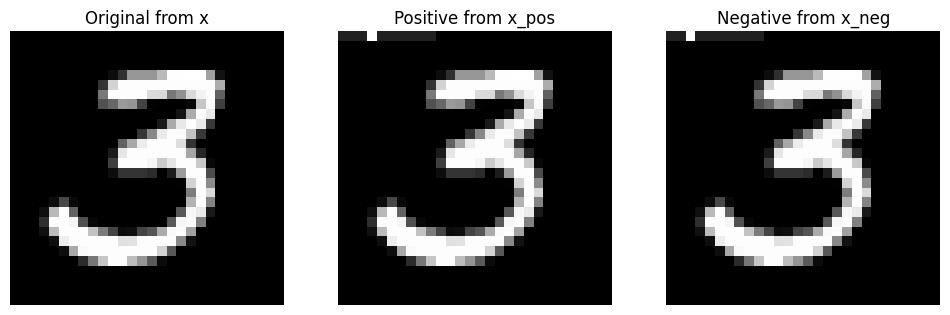

In [ ]:
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt

# Move tensors to CPU
x_cpu = x[2].cpu()
x_pos_cpu = x_pos[2].cpu()
x_neg_cpu = x_neg[2].cpu()

# Plot the images
plt.figure(figsize=(12, 4))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(x_cpu.view(28, 28), cmap='gray')  # Assuming MNIST-like images with size 28x28
plt.title('Original from x')
plt.axis('off')

# Positive image
plt.subplot(1, 3, 2)
plt.imshow(x_pos_cpu.view(28, 28), cmap='gray')
plt.title('Positive from x_pos')
plt.axis('off')

# Negative image
plt.subplot(1, 3, 3)
plt.imshow(x_neg_cpu.view(28, 28), cmap='gray')
plt.title('Negative from x_neg')
plt.axis('off')

# Show the plot
plt.show()

In [ ]:
class Net(torch.nn.Module):

    def __init__(self, dims):
        self.num_epochs = 1000
        super().__init__()
        self.layers = []
        for d in range(len(dims) - 1):
            self.layers += [Layer(dims[d], dims[d + 1]).cuda()]

    def predict(self, x):
        goodness_per_label = []
        for label in range(10):
            h = x.clone()
            h[:, :10] *= 0.0
            h[range(x.shape[0]), label] = x.max()
            goodness = []
            for layer in self.layers:
                h = layer(h)
                goodness += [h.pow(2).mean(1)]
            goodness_per_label += [sum(goodness).unsqueeze(1)]
        goodness_per_label = torch.cat(goodness_per_label, 1)
        return goodness_per_label.argmax(1)


In [ ]:
class Layer(nn.Linear):
    def __init__(self, in_features, out_features,
                 bias=True, device=None, dtype=None):
        super().__init__(in_features, out_features, bias, device, dtype)
        self.relu = torch.nn.ReLU()
        self.opt = Adam(self.parameters(), lr=0.03)
        self.threshold = 2.0


    def forward(self, x):
        x_direction = x / (x.norm(2, 1, keepdim=True) + 1e-4)
        return self.relu(
            torch.mm(x_direction, self.weight.T) +
            self.bias.unsqueeze(0))

#Training and Results :

In [ ]:

net = Net([784, 500, 500])

#training :
for epoch in range(net.num_epochs):
    h_pos, h_neg = x_pos, x_neg
    for  layer in net.layers:
      g_pos = layer.forward(h_pos).pow(2).mean(1)
      g_neg = layer.forward(h_neg).pow(2).mean(1)

      loss = torch.log(1 + torch.exp(torch.cat([
          -g_pos + layer.threshold,
          g_neg - layer.threshold]))).mean()

      layer.opt.zero_grad()
      loss.backward()
      layer.opt.step()
      h_pos, h_neg = layer.forward(h_pos).detach(), layer.forward(h_neg).detach()


print('train error:', 1.0 - net.predict(x).eq(y).float().mean().item())



train error: 0.058480024337768555


# Testing and Results

In [ ]:
x_te, y_te = next(iter(test))
x_te, y_te = x_te.cuda(), y_te.cuda()

print('test error:', 1.0 - net.predict(x_te).eq(y_te).float().mean().item())

test error: 0.05870002508163452


# **Unsupervised  :**

---







**Data Loading :**

In [8]:
torch.manual_seed(1234)
train_size=50000
test_size=10000

transform = Compose([ToTensor(),Normalize((0.1307,), (0.3081,)),Lambda(lambda x: torch.flatten(x))])
train = DataLoader(MNIST('./data/', train=True,download=True,transform=transform),batch_size=train_size, shuffle=True)
test = DataLoader(MNIST('./data/', train=False,download=True,transform=transform),batch_size=test_size, shuffle=False)

x, y = next(iter(train))
x, y = x.cuda(), y.cuda()
x_pos = x.clone()

x_test, y_test = next(iter(test))
x_test, y_test = x_test.cuda(), y_test.cuda()

## **Generating The Mask :**

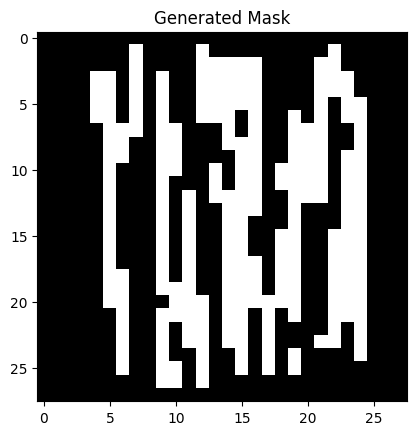

In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt


import torch
import torch.nn.functional as F

def create_mask(image_size, blur_iterations=5):
    random_image = torch.rand(1, 1, *image_size)
    blur_filter = torch.tensor([1/4, 1/2, 1/4], dtype=torch.float32).view(1, 1, 3, 1)
    for _ in range(blur_iterations):
        random_image = F.conv2d(random_image, blur_filter, stride=1, padding=1)
    mask = (random_image > 0.5).float()
    mask = F.interpolate(mask, size=image_size, mode='nearest')

    return mask

image_size = (28, 28)
mask = create_mask(image_size).squeeze()
plt.imshow(mask.numpy(), cmap='gray')
plt.title('Generated Mask')
plt.show()

**Applying the mask to an image from the dataset ---> (just for show the mask efect):**

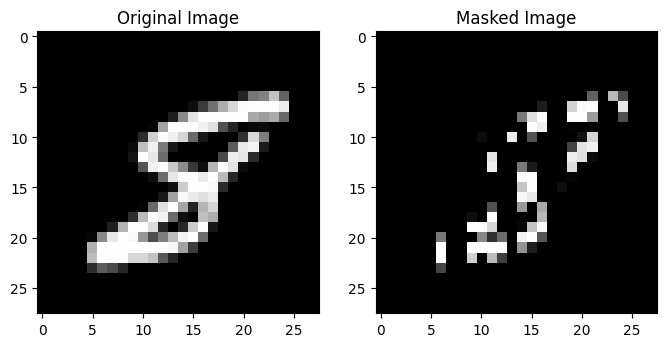

In [6]:
x_orig = x[6].view(28,28).cpu()
x_masked = x_orig*mask.cpu()
x_masked[x_masked<0.000001] = 0.0
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(x_orig.reshape(28, 28), cmap='gray')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(x_masked.reshape(28, 28), cmap='gray')
plt.title('Masked Image')

plt.show()

## **Negative Data Generation :**

I permute the original data set and by following method generate negative data :

$$x_{neg}[i] = x_{original}[i] * mask + (1-mask)*x_{permuted}[i]$$

**bellow cells are the implementations :**

First generating a permuted dataset from the original one :

Now applying the method to obtain negative data :

In [9]:
import numpy as np
import cv2
import numpy as np


def create_mask(image_size):
    mask = np.random.randint(0, 2, image_size).astype(np.float32)
    for i in range(5):
        mask = cv2.filter2D(mask, -1, np.array([[1/4, 1/2, 1/4]]))
        mask = cv2.filter2D(mask, -1, np.array([[1/4], [1/2], [1/4]]))
    mask[mask> 0.5] = 1
    mask[mask <= 0.5] = 0
    return torch.tensor(mask)


def negative_generate(data):
        clone_data = data.clone()

        indices = np.arange(clone_data.shape[0])
        np.random.shuffle(indices)
        permutation = torch.tensor(indices)
        permuted = torch.index_select(clone_data, 0, permutation)

        hybrid_data = torch.zeros(clone_data.shape)

        for row in range(clone_data.shape[0]):
                mask1 = create_mask((28, 28))
                mask2 = 1-mask1
                hybrid_data_ = mask1* clone_data[row].view(28,28) + mask2*permuted[row].view(28,28)
                hybrid_data[row] = hybrid_data_.view(-1)

        return hybrid_data

In [10]:
class Unsupervised_net(torch.nn.Module):

    def __init__(self, dims):
        self.num_epochs = 1000
        super().__init__()
        self.layers = []
        for d in range(len(dims) - 1):
            self.layers += [Unsupervised_layer(dims[d], dims[d + 1]).cuda()]

    def predict(self, x):
        layer_outputs = []
        h = x.clone()
        for layer in self.layers:
            h = layer(h)
            layer_outputs.append(h)
        final_output = torch.cat(layer_outputs, dim=-1)
        return final_output


In [11]:
class Unsupervised_layer(nn.Linear):
    def __init__(self, in_features, out_features,
                 bias=True, device=None, dtype=None):
        super().__init__(in_features, out_features, bias, device, dtype)
        self.relu = torch.nn.ReLU()
        self.opt = Adam(self.parameters(), lr=0.03)
        self.threshold = 2.0

    def forward(self, x):
        x_direction = x / (x.norm(2, 1, keepdim=True) + 1e-4)
        return self.relu(
            torch.mm(x_direction, self.weight.T) +
            self.bias.unsqueeze(0))



## **Training :**

In [12]:
from torchvision import transforms
batch_size = 128

transformer = transforms.Compose([transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,)),
                        transforms.Lambda(lambda x: x.view(-1))])

train_dataloader = DataLoader(MNIST('./data/',train=True,download=True,transform=transformer),
                              batch_size=batch_size, shuffle=True)

test_dataloader = DataLoader(MNIST('./data/',train=False,download=True,transform=transformer),
                              batch_size=batch_size, shuffle=True)

net = Unsupervised_net([784, 500, 500])

for (data, targets) in tqdm(train_dataloader):
    x_pos = data.clone().cuda()
    x_neg = negative_generate(data).cuda()
    h_pos, h_neg = x_pos, x_neg
    for  layer in net.layers:
      g_pos = layer.forward(h_pos).pow(2).mean(1)
      g_neg = layer.forward(h_neg).pow(2).mean(1)

      loss = torch.log(1 + torch.exp(torch.cat([
          -g_pos + layer.threshold,
          g_neg - layer.threshold]))).mean()

      layer.opt.zero_grad()
      loss.backward()
      layer.opt.step()
      h_pos, h_neg = layer.forward(h_pos).detach(), layer.forward(h_neg).detach()





100%|██████████| 469/469 [00:39<00:00, 11.86it/s]


Train and Test unsupervised prediction :



In [13]:
from torchvision import transforms


In [14]:
# train
train_layers_ouputs= []
train_targets = []

for (data, targets) in tqdm(train_dataloader):
    train_layers_ouputs.append(net.predict(data.cuda()))
    train_targets.append(targets)

train_layers_ouputs = torch.cat(train_layers_ouputs, dim=0).cuda().detach()
train_targets = torch.cat(train_targets, dim=-1).cuda().detach()

100%|██████████| 469/469 [00:12<00:00, 36.17it/s]


In [15]:
# test
layers_ouputs= []
test_targets = []

for (data, targets) in tqdm(test_dataloader):
    layers_ouputs.append(net.predict(data.cuda()))
    test_targets.append(targets)

layers_ouputs = torch.cat(layers_ouputs, dim=0).cuda().detach()
test_targets = torch.cat(test_targets, dim=-1).cuda().detach()

100%|██████████| 79/79 [00:02<00:00, 37.53it/s]


In [16]:
from torch.utils.data import DataLoader,Dataset
class Custom_Dataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [17]:
batch_size = 64

train_dataset = Custom_Dataset(train_layers_ouputs, train_targets)
train_dataloader_ = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = Custom_Dataset(layers_ouputs, test_targets)
test_dataloader_ = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [18]:
class OneLayerNet(nn.Module):
    def __init__(self, input_size, num_classes):
        super(OneLayerNet, self).__init__()
        self.fc = nn.Linear(input_size, num_classes)

    def forward(self, x):
        x = self.fc(x)
        return torch.softmax(x, dim=1)
model = OneLayerNet(1000, 10).cuda()

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
num_epochs = 100

for _ in range(num_epochs):
    for (data, targets) in tqdm(train_dataloader_):
        data = data.cuda()
        targets = targets.cuda()
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

100%|██████████| 938/938 [00:01<00:00, 669.00it/s]


In [20]:
with torch.no_grad():
    train_accuracy = 0
    for (data, targets) in tqdm(train_dataloader_):
        data = data.cuda()
        targets = targets.cuda()
        train_outputs = model(data)
        _, predicted_train = torch.max(train_outputs, 1)
        train_accuracy += (predicted_train == targets).sum().item() / len(targets)


print('train accuracy: ',(train_accuracy/len(train_dataloader_))*100)

100%|██████████| 938/938 [00:00<00:00, 1346.37it/s]

train accuracy:  92.96042110874201


In [21]:
with torch.no_grad():
    test_accuracy = 0
    for (data, targets) in tqdm(test_dataloader_):
        data = data.cuda()
        targets = targets.cuda()
        test_outputs = model(data)
        _, predicted_test = torch.max(test_outputs, 1)
        test_accuracy += (predicted_test == targets).sum().item() / len(targets)

print('test accuracy: ',(test_accuracy/len(test_dataloader_))*100)

100%|██████████| 157/157 [00:00<00:00, 1255.56it/s]

test accuracy:  92.92396496815286
